In [1]:
# default_exp optim_w_augment_2
%load_ext autoreload
%autoreload 2

# Optimising With Augmentation: Run 2 With Improvements

> Optimisation the whole alphabet using the augmented OCR model and with augmented renderings for `OCRLoss`. A second run with the updated font model and some loss function improvements.

In [2]:
#export
from aifont.core import *
from aifont.fontlearner import *
from aifont.fontsampler import *
from aifont.ocrlearner import *
from collections import OrderedDict
from enum import Enum, auto
from fastai.data.all import *
from fastai.vision.all import *
import gc
from nbdev.showdoc import *
from pandas import DataFrame
from PIL.ImageOps import invert
import pydiffvg
import torch
from typing import Callable, List, Protocol, Tuple, Union

## Font Learner Factory

In [3]:
#export
def get_match_font_learner(seed = 42, 
    font_fn = "Arial.ttf",
    font_size = .8,
    samples=3, # We don't care so much about noise here
    **kwargs
    ) -> VectorLearner:
    gc.collect()
    cb = DebugCB(vocal=False)
    learner = create_font_learner(loss_type=LossType.MATCH_FONT,
                                  match_font_path=SYS_FONT_PATH/font_fn,
                                  match_font_size=font_size,
                                  letters=None,
                                  cbs=cb,
                                  folder=None,
                                  n_colors_out=1,
                                  lr=1e-2, 
                                  init_range=2.,
                                  seed=seed,
                                  samples=samples,
                                  **kwargs)
    return learner

In [4]:
#export
def get_learner(seed = 42, 
    version = "aug", 
    use_ocr_tfms = True,
    tfms_p = 1.,
    tfms_set = "xstrong2",
    **kwargs
    ) -> VectorLearner:
    gc.collect()
    if 'ocr_model' not in locals() or ocr_model is None:
        ocr_model = load_ocr_model(arch=kaggle_cnn_a_with_res, 
                                   df=get_combined_az_and_tmnist_df,
                                   version=version)
    cb = DebugCB(vocal=False)
    ocr_tfms = None
    if use_ocr_tfms:
        # These are the same ones as used for the OCR model
        max_rotate = 15.0
        max_warp = .25
        size = 28
        if   tfms_set == "strong":           blur = GaussianBlur(p=tfms_p, random_size=(5, 9), sigma=10.)
        elif tfms_set.startswith("xstrong"): blur = GaussianBlur(p=tfms_p, kernel_size=(9, 9), sigma=10.)
        else:                                blur = GaussianBlur(p=tfms_p, random_size=5)
        noise = Noise(p=tfms_p, f=(0., .6))
        translate = TranslateAndPad(p=tfms_p)
        tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=max_rotate, 
                              min_zoom=0.85, max_zoom=1.15, max_warp=max_warp, p_affine=tfms_p, 
                              p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                              pad_mode='reflection', align_corners=True, batch=False, 
                              min_scale=1.0)
        warp = tfms[0]
        ocr_tfms = [warp, blur]
        if tfms_set == "default":  ocr_tfms += noise
        if tfms_set == "xstrong2": ocr_tfms = [translate, blur]
    learner = create_font_learner(ocr_tfms=ocr_tfms,
                                letters=None,
                                cbs=cb,
                                folder=None,
                                ocr_model=ocr_model,
                                n_colors_out=1,
                                lr=1e-1, 
                                init_range=2.,
                                seed=seed,
                                **kwargs)
    if use_ocr_tfms: assert len(learner.loss_func.ocr_loss.tfms) == len(ocr_tfms)
    return learner

## Optimisation Utilities

Copied from `05_full_aphabet_optimisation.ipynb`. 

In [5]:
DUMP_FOLDER = "results/test_nb10_augmented"

class ParamRecorderCB(Callback):
    best: dict = None
    best_on = None
    last_best_loss = None
    results: list[dict] = []
    def __init__(self, 
        max_epochs_after_best: int = None, 
        *args, **kwargs
        ):
        super(ParamRecorderCB, self).__init__(*args, **kwargs)
        store_attr("max_epochs_after_best")
    def before_fit(self):
        self.best_on = 0
        if self.best is None: self.last_best_loss = self.get_current_loss()
    def after_loss(self):
        if not self.training: return
        l  = self.loss.item()
        lr = self.opt.hypers[-1]["lr"]
        p  = self.get_param_dict()
        if not self.best or l < self.best["loss"]:
            self.best = dict(loss=l, lr=l, params=p)
            self.best_on = self.epoch
        elif self.max_epochs_after_best is not None and \
             self.epoch - self.best_on > self.max_epochs_after_best:
            raise CancelFitException()
    def after_fit(self):
        impr = self.last_best_loss - self.best["loss"]
        self.last_best_loss = self.best["loss"]
        impr_fr = impr / (self.last_best_loss + EPS)
        self.results.append(dict(impr=impr, 
                                 impr_fr=impr_fr,
                                 stopped_at=self.epoch,
                                 n_epochs=self.n_epoch,
                                 **self.best))
        print(f"Improvement {impr:.4f} ({impr_fr:.2%})")
    def reset_to_best(self):
        """Reset to the best saved parameters."""
        assert self.best
        self.load_param_dict(self.best["params"])

def plot_variation_results(
    variations: list[dict],
    figsize = (6, 6),
    lim: float = None
    ) -> None:
    """Plot the results from `fancy_fit_2_variations`."""
    df = DataFrame(variations)
    if lim is None: lim = math.ceil(max(df.init_loss)) 
    init_med, final_med = np.median(df.init_loss), np.median(df.final_loss)
    impr_med = np.median((df.init_loss - df.final_loss) / df.init_loss)
    min_loss = df.final_loss.min()
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    ax.set_xlim(0, lim), ax.set_ylim(0, lim)
    ax.scatter(df.init_loss, df.final_loss)
    ax.scatter(init_med, final_med)
    plt.suptitle(f"Initial losses vs final losses\n(median in orange, median improvement {impr_med:.2%},\nmin loss {min_loss:.4f})")
    plt.xlabel(f"Initial loss"), plt.ylabel(f"Final loss")

def show_variation_renders(
    variations: Union[list[dict], DataFrame],
    n = 12,
    n_cols = 4,
    fig_width = 14,
    incl_tfms = False,
    learner: VectorLearner = None,
    rerender = False
    ) -> plt.Figure:
    """Show the rendered images together with losses, possibly paired with loss-function-transformed images."""
    if incl_tfms and "img_with_tfms" not in variations[0]:
        assert learner is not None, "You must supply a learner if incl_tfms is True and variations don't contain img_with_tfms."
    assert not rerender or learner, "You must supply a learner if rerender is True"
    if type(variations) is list: variations = DataFrame(variations)
    variations = variations.sort_values(by="final_loss").reset_index()
    n_imgs = n if n is not None and len(variations) > n else len(variations)
    if incl_tfms: n_imgs *= 2
    n_rows = math.ceil(n_imgs / n_cols)
    _img = variations.iloc[0].img
    img_ratio = _img.height / _img.width
    fig_height = (fig_width / n_cols * img_ratio + .5) * n_rows
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    axs = axs.flatten()
    def _do_rend(v, apply_tfms=False):
        return learner.load_param_dict(v.final_params).render_letters(apply_tfms=apply_tfms)
    for i, ax in enumerate(axs):
        if i >= n_imgs: break
        is_tfmd = incl_tfms and i % 2 == 1
        v = variations.iloc[i//2 if incl_tfms else i]
        if is_tfmd: img = v.img_with_tfms if not rerender and "img_with_tfms" in v else _do_rend(v, True)
        else:       img = v.img if not rerender else _do_rend(v)
        ax.imshow(img)
        ax.set_title("With loss tfms" if is_tfmd else f"Loss {v.final_loss:.4f}")
    title = "Rendered fonts and losses"
    if incl_tfms: title += "\nwith examples of loss-function-transformed images\n(Note that true transforms may be randomised)"
    fig.suptitle(title)
    plt.show()
    return fig

def avg_loss(
    learner,
    n = 20,
    return_list = False
    ) -> float:
    """Calc avg loss over `n` iterations."""
    losses = []
    for i in range(n): losses.append(learner.get_current_loss())
    return losses if return_list else sum(losses) / n

def print_losses(
    losses: Union[list, np.array], 
    msg = None
    ) -> dict:
    """Print basic stats of losses."""
    if msg is not None: msg += ": "
    losses = np.array(losses)
    l_mean = losses.mean()
    l_std = losses.std()
    l_spread = losses.max() - losses.min()
    print(f"{msg}Mean: {l_mean:.4f} • SD: {l_std:.4f} ({l_std / l_mean:.1%}) • Spread {l_spread:.4f} ({l_spread / l_mean:.1%})")
    return(dict(mean=l_mean, std=l_std, spread=l_spread))

def get_individual_losses(
    learner,
    iters = 20
    ) -> np.array:
    """Get losses for individual letters. Mean over `iters`."""
    loss = OCRLoss(ocr_model=load_ocr_model(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df),
                   tfms=learner.loss_func.ocr_loss.tfms, reduction='none')
    b = L(learner.dls.train)[0]
    x, y = b
    losses = {k.item(): [] for k in y}
    for i in range(iters):
        v = learner.model(x)
        ll = loss(v, y)
        for k, l in zip(y, ll[0]): losses[k.item()].append(l.item())
    losses_list = [losses[k] if k in losses else [-1.] for k in range(len(learner.vocab))]
    means = [np.array(l).mean() for l in losses_list]
    return np.array(means)

def plot_current_individual_losses(
    learner,
    **kwargs
    ) -> np.array:
    means = get_individual_losses(learner, **kwargs)
    letters = learner.vocab
    fig = plt.figure()
    ax = fig.add_subplot()
    line, = ax.plot(means)
    ax.set_xticks(range(len(letters)), labels=letters)
    return means

def try_params(
    learner,
    param = "Width, HNU",
    steps = 40,
    min = -4., max = 4., 
    loss_iters = 20
    ) -> DataFrame:
    """Try different param values and record individual letters losses (mean overs `loss_iters`)."""
    assert steps > 1
    self = learner
    lf = self.loss_func
    with debug(lf):
        model = self.model
        stats = []
        for i in range(steps):
            report("Trying params", prog = i / steps)
            v = min + (max - min) * i / (steps - 1)
            model.set_param(param, v)
            means = {f"loss_{k}": v for k, v in zip(learner.vocab, get_individual_losses(learner, iters=loss_iters))}
            d = {
                "value": model.get_param(param).item(), # There's a discrepancy between v and this
                "interpolated_value": model.get_param_value(param).item(),
                **means
                }
            stats.append(d)
    return DataFrame(stats)

def create_or_load_variations(fn: str,
    plot = True,
    **fancy_fit_args
    ) -> list[dict]:
    """Shortcut for `fancy_fit_2_variations` that saves the results. If there 
       already are results saved with `fn`, loads them instead."""
    fp = os.path.join(DUMP_FOLDER, fn)
    try: res = load(fp)
    except: 
        res = fancy_fit_2_variations(**fancy_fit_args, filename=fn)
        dump(res, fp)
    if plot: plot_variation_results(res, lim=4)
    return res

def apply_best_params(learner,
    variations: list
    ) -> VectorLearner:
    "Apply the params with the lowest loss from variations to learner."
    best = sorted(variations, key=lambda x: x["final_loss"])[0]
    learner.load_param_dict(best["final_params"])
    return learner

def fancy_fit_3_variations_match_font(filename: str,
    variations = 50,
    dump_folder = DUMP_FOLDER,
    zero_width = True,
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_match_font_learner()
        self.reset_parameters()
        if zero_width:
            for p in self.param_names:
                if p.startswith("Width"): self.set_param(p, 0.)
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        with self.no_progress(): var_res = fancy_fit_3(self, msg=f"Variation {k + 1}/{variations} • ", **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   var_res[-1]["params"],
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters(),
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def fancy_fit_3_match_font(learner: VectorLearner,
    epochs = 40,
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 20,
    abort_if = 0.75,
    abort_at = 2,
    msg = ""
    ) -> list[dict]:
    """Perform multiple fitting sessions."""
    res = []
    orig_loss = learner.get_current_loss()
    for i in range(iters):
        report(f"{msg}Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        l = learner.get_current_loss()
        res.append(dict(lr=lr,
                        loss=l,
                        params=learner.get_param_dict() ))
        if i >= abort_at and l > abort_if * orig_loss: break
        lr *= lr_factor
        epochs += epoch_increment
    clear()
    return res

def fancy_fit_4_variations(
    filename: str,
    variations = 20,
    dump_folder = DUMP_FOLDER,
    bs = None,
    version = "aug", 
    use_ocr_tfms = True,
    tfms_p = 1.,
    tfms_set = "xstrong2",
    zero_width = False,
    **kwargs
    ) -> list[dict]:
    """Create `iters` optimised iterations by reinitialising parameters either randomly
        or from `initial_params` list and training for `epochs` with `lrs`."""
    path = os.path.join(dump_folder, filename)
    results = []
    for k in range(variations):
        gc.collect()
        self = get_learner(seed=None, bs=bs, version=version, use_ocr_tfms=use_ocr_tfms, tfms_p=tfms_p, tfms_set=tfms_set)
        self.reset_parameters()
        if zero_width:
            for p in self.param_names:
                if p.startswith("Width"): self.set_param(p, 0.)
        init_pars = self.get_param_dict()
        init_loss = self.get_current_loss()
        with self.no_progress(): var_res = fancy_fit_4(self, msg=f"Variation {k + 1}/{variations} • ", **kwargs)
        res = {
            "initial_params": init_pars,
            "final_params":   var_res[-1]["params"],
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            self.render_letters(),
            "img_with_tfms":  self.render_letters(apply_tfms=True)
            }
        dump(res, f"{path}{k}.pkl")
        results.append(res)
    dump(results, f"{path}all.pkl")
    return results

def fancy_fit_4(learner: VectorLearner,
    epochs = 80, # 40
    epoch_increment = 0,
    lr = 1e-1,
    lr_factor = .9,
    iters = 3, # 20
    abort_if = 0.75,
    abort_at = 1, # 2
    max_init_loss = 2., # N/A
    max_reinits = 100,  # N/A
    msg = ""
    ) -> list[dict]:
    """Perform multiple fitting sessions."""
    res = []
    orig_loss = learner.get_current_loss()
    if max_init_loss is not None:
        j = 0
        while orig_loss > max_init_loss:
            if j >= max_reinits: return [dict(lr=lr,
                                              loss=orig_loss,
                                              params=learner.get_param_dict(),
                                              note="Max reinits exceeded")]
            j += 1
            learner.reset_parameters()
            orig_loss = learner.get_current_loss()
    for i in range(iters):
        report(f"{msg}Iteration {i + 1}/{iters} • lr {lr:.4f}")
        learner.fit(epochs, lr)
        l = learner.get_current_loss()
        res.append(dict(lr=lr,
                        loss=l,
                        params=learner.get_param_dict()))
        if i >= abort_at and l > abort_if * orig_loss: break
        lr *= lr_factor
        epochs += epoch_increment
    clear()
    return res

## Other Utilities

In [6]:
def get_learner_for_fit_letters(calc_loss = False
    ) -> Union[VectorLearner, Tuple[float, VectorLearner]]:
    "Shortcut for getting a learner for tests in this experiment."
    gc.collect()
    learner_args = dict(version = "aug", 
                        use_ocr_tfms = True,
                        tfms_p = 1.,
                        tfms_set = "xstrong",
                        bs = 4 * len(VOCAB_UC))
    learner = get_learner(seed = 42, **learner_args)
    fn_exp5 = "variations_exp5_xstrong_aug"
    fp_exp5 = os.path.join(DUMP_FOLDER, fn_exp5)
    res_exp5 = load(fp_exp5)
    apply_best_params(learner, res_exp5)
    if calc_loss:
        init_loss = learner.get_current_loss(iters=10)
        print(f"Init loss: {init_loss}")
        return init_loss, learner
    else: return learner

def get_font_ocr_loss(
    learner: VectorLearner,
    fn: str = "Arial.ttf",
    folder: Path = SYS_FONT_PATH,
    size_range = (0.5, 1.0),
    steps = 20
    ) -> List[dict]:
    """Find the optimal size for the font and display the OCR loss for that."""
    assert steps > 1
    font_path = folder/fn
    vocab = learner.vocab
    m = learner.model
    w,h = m.canvas_width,m.canvas_height
    lf = learner.loss_func.ocr_loss
    with eval_model(m): x,y = list(learner.dls.train)[0]
    res = []
    sizes = set([round(h * (size_range[0] + i * (size_range[1] - size_range[0]) / (steps - 1))) for i in range(steps)])
    for size in sizes:
        imgs = []
        for x_i in x:
            l = vocab[x_i]
            imgs.append(render_text(font_path, text=l, text_size=size, image_width=w, image_height=h, as_normalised_array=True))
        img_t = concat_tensors(imgs).reshape(-1, 1, w, h)
        loss = lf(img_t, y).item()
        res.append(dict(size=size, loss=loss, imgs=imgs, imgs_tfmd=lf.apply_tfms(img_t)))
    res.sort(key=lambda x: x["loss"])
    print(f"Best loss for {fn}: {res[0]['loss']:.4f} at size {res[0]['size']:d}")
    return res

def show_renders_and_target(learner: VectorLearner,
    grid_scale = .5
    ) -> None:
    """Show rendered letters and target letters."""
    pred = learner.render_letters(grid_scale=grid_scale)
    targ = image_grid(learner.loss_func.target_letters, scale=grid_scale).convert('L')
    size = targ.size
    targ2 = Image.new('RGB', size=size, color="white")
    targ2.paste((255,0,0), mask=invert(targ))
    mask = Image.new('L', size=size, color=128)
    comp = Image.composite(pred, targ2, mask)
    grid_size = (3 * size[0], size[1])
    grid = Image.new('RGB', size=grid_size, color="white")
    for i,img in enumerate([comp, pred, targ]): grid.paste(img, box=(i * size[0], 0))
    print(f"Loss: {learner.get_current_loss()}")
    display(grid)

def plot_variation_losses(variations: list[dict],
    figsize = (10, 10),
    y_range: Tuple[float, float] = None
    ) -> None:
    """Plot the loss trajectories from `fancy_fit_2/3_variations`."""
    fig = plt.figure(figsize=figsize)
    ax  = plt.gca()
    if y_range: ax.set_ylim(*y_range)
    for v in variations:
        res = v["full_res"]
        losses = [v["init_loss"]] + [o["loss"] for o in res]
        ax.plot(range(len(res) + 1), losses)
    plt.xticks(range(1 + max([len(v["full_res"]) for v in variations])))
    plt.xlabel(f"Iterations completed")
    plt.ylabel(f"Loss")

## 1. Experiment 1 Rerun: Optimise With Strong Impairment

> Our font model has been updated and we should probably not use the parameters in `FONT_MATCHING_PARAM_SPECS` as they might militate against the random displacement, but this is not clear. Actually, they might help center the letter in the rendered area, which itself is appropriate.

Create the augmentation before loss to randomly offset the letters a bit.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")
/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/fontlearner.py:2590: UserWarning: Using default input_shape: (28, 28)
  warn(f"Using default input_shape: {input_shape}")


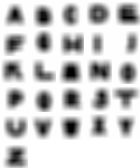

In [7]:
learner = get_learner()
size = (learner.model.canvas_width, learner.model.canvas_width)
learner.show_batch()
# img = learner.render_letter("A", apply_tfms=True)
# # img.crop_pad(size, tl=(-5, -5), pad_mode=PadMode.Reflection)
# image_grid([learner.render_letter("A", apply_tfms=True) for _ in range(10)], scale=5.)

In [8]:
fn_1 = "strong_aug_2_exp1a_"
fn_2 = "strong_aug_2_exp1b_"
fn_3 = "strong_aug_2_exp1c_"
if False:
    fancy_fit_4_variations(fn_1,
        version = "aug", 
        use_ocr_tfms = True,
        tfms_p = 1.,
        tfms_set = "xstrong2",
        bs=4 * len(VOCAB_UC)
    )
    fancy_fit_4_variations(fn_2,
        variations = 40,
        version = "aug", 
        use_ocr_tfms = True,
        tfms_p = 1.,
        tfms_set = "xstrong2",
        bs=4 * len(VOCAB_UC)
    )
    fancy_fit_4_variations(fn_3,
        variations = 40,
        version = "aug", 
        use_ocr_tfms = True,
        tfms_p = .5, # <<<
        tfms_set = "xstrong2",
        bs=4 * len(VOCAB_UC)
    )
res_exp1 = load(f"{DUMP_FOLDER}/{fn_1}all")
res_exp1.extend(load(f"{DUMP_FOLDER}/{fn_2}all"))
# res_exp2 = []
# for i in range(18): res_exp2.append(load(f"{DUMP_FOLDER}/{fn_3}{i}"))
res_exp2 = load(f"{DUMP_FOLDER}/{fn_3}all")
len(res_exp1), len(res_exp2)

(60, 18)

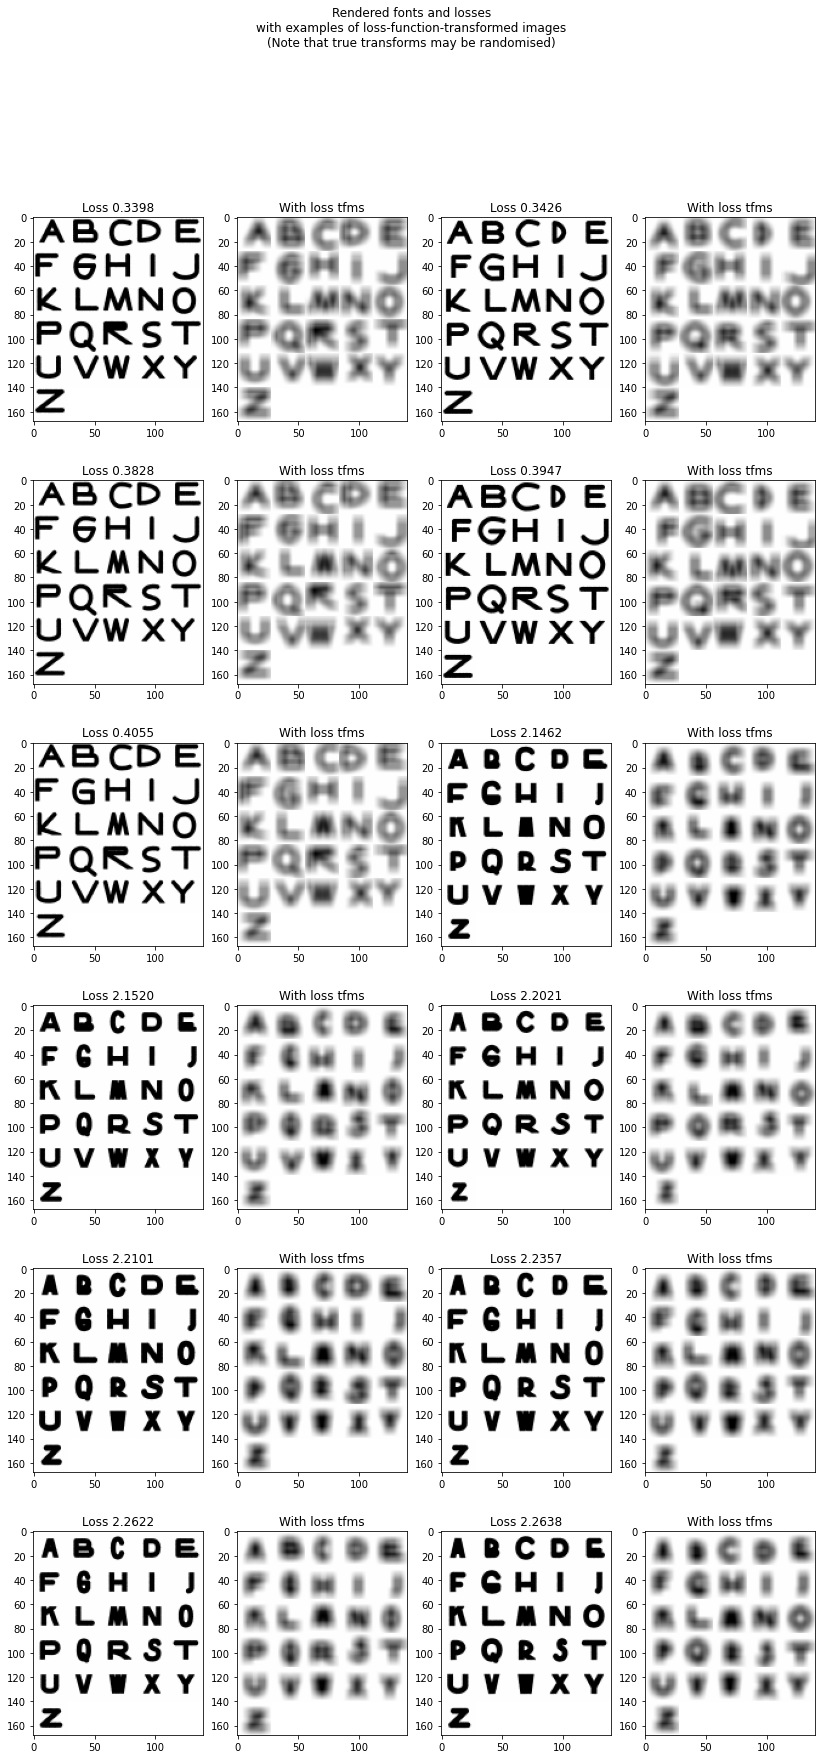

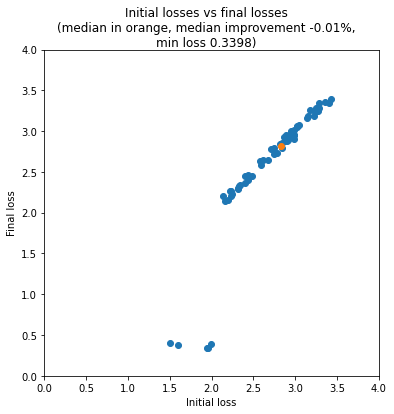

In [9]:
show_variation_renders(res_exp1, learner=learner, incl_tfms=True)
plot_variation_results(res_exp1)

We notice now that we made two mistakes with the experiment:

1. The initial loss cut-off at 2.0 is too low, as only four of the 60 variation could reach that within 100 reinitialisation iterations.
2. We should have frozen the offset parameters used for font matching.

Let's see if we can improve upon the best results from here with first freezing the offsets.

In [10]:
if False:
    bs = len(VOCAB_UC) * 4
    iters = 3
    lr_start = 1e-1
    lr_factor = .9
    epochs = 100
    loss_iters = 10
    best_res = sorted(res_exp1, key=lambda x: x["final_loss"])[:4]
    new_res = []
    for j,r in enumerate(best_res):
        learner = get_learner(bs=bs)
        learner.load_param_dict(r["final_params"])
        init_loss = learner.get_current_loss(loss_iters)
        # for p in list(OFFSET_PARAM_SPECS.keys()):
        #     learner.set_param(p, 0.)
        #     learner.freeze_params([p])
        var_res = []
        lr = lr_start
        for i in range(iters):
            learner.fit(epochs, lr=lr)
            var_res.append(dict(lr=lr,
                                loss=learner.get_current_loss(loss_iters),
                                params=learner.get_param_dict()))
            lr *= lr_factor
            clear()
            report(prog=(j*iters+i+1) / (len(best_res)*iters))
        new_res.append({
            "initial_params": r["final_params"],
            "final_params":   var_res[-1]["params"],
            "init_loss":      init_loss,
            "final_loss":     var_res[-1]["loss"],
            "full_res":       var_res,
            "img":            learner.render_letters(),
            "img_with_tfms":  learner.render_letters(apply_tfms=True)
            })

fn_4 = "strong_aug_2_exp1a_pt2"
# dump(new_res, f"{DUMP_FOLDER}/{fn_4}")
new_res = load(f"{DUMP_FOLDER}/{fn_4}")

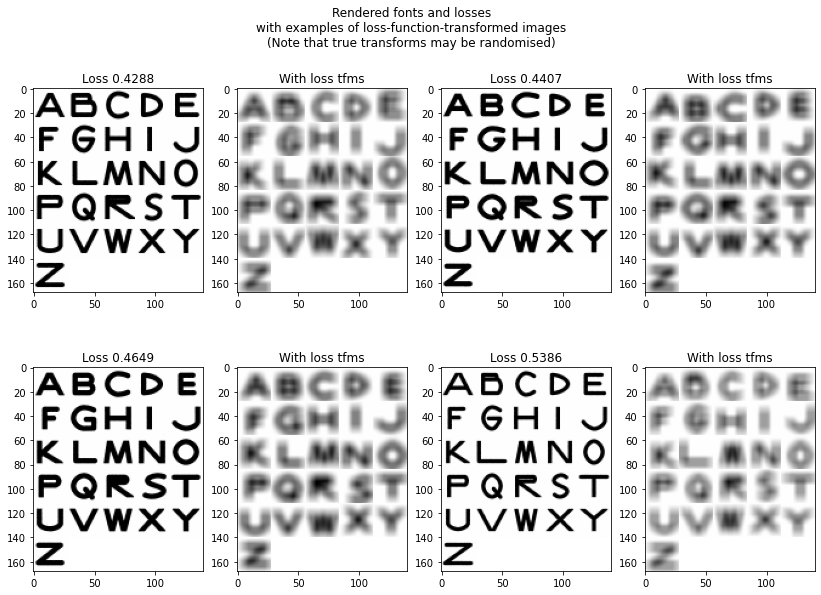

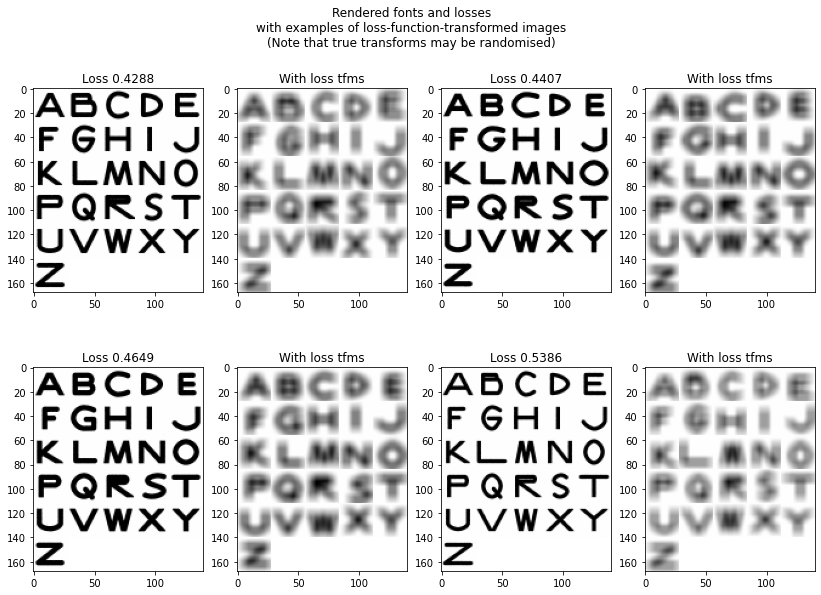

In [11]:
show_variation_renders(new_res, learner=learner, incl_tfms=True, rerender=True)

## Export

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted 01_fontsampler.ipynb.
Converted 02_ocrlearner.ipynb.
Converted 03_fontlearner.ipynb.
Converted index.ipynb.
